# Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'ai-practice'
%cd /content/drive/My\ Drive/$FOLDERNAME
from load_mnist import load_MNIST
train_X, train_y, test_X, test_y = load_MNIST()

%load_ext autoreload
%autoreload 2

Mounted at /content/drive
/content/drive/My Drive/ML practice
train_X: (60000, 28, 28) train_Y: (60000,)
test_X: (10000, 28, 28) test_Y: (10000,)


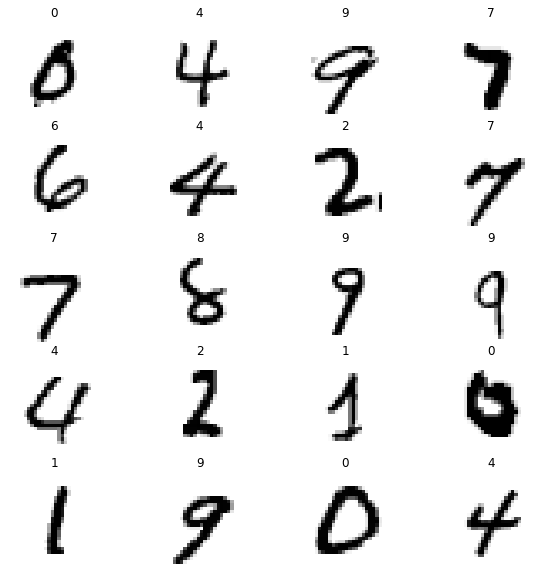

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import random

num_train = train_X.shape[0]
plt.subplots(figsize=(10, 10))
for i in range(20):
  plt.subplot(5, 4, i+1)
  idx = random.randrange(num_train)
  plt.imshow(train_X[idx], cmap='gray_r', vmin=0, vmax=255)
  plt.axis('off')
  plt.title(train_y[idx])

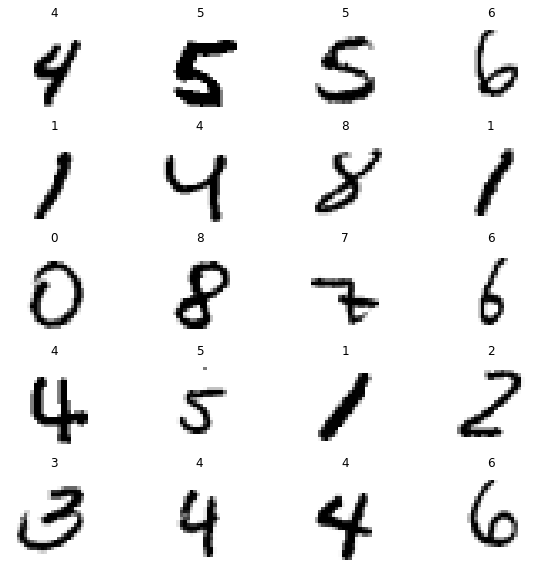

In [ ]:
num_test = test_X.shape[0]
plt.subplots(figsize=(10, 10))
for i in range(20):
  plt.subplot(5, 4, i+1)
  idx = random.randrange(num_test)
  plt.imshow(test_X[idx], cmap='gray_r', vmin=0, vmax=255)
  plt.axis('off')
  plt.title(test_y[idx])

# KNN

In [ ]:
from classifiers.k_nearest_neighbors import KNN
classifier_KNN = KNN()
classifier_KNN.train(train_X.reshape(num_train, -1), train_y)
pred_y = classifier_KNN.predict(test_X.reshape(num_test, -1), 1)
print("Accuracy:", (pred_y == test_y).sum() / num_test)

Accuracy: 0.9691


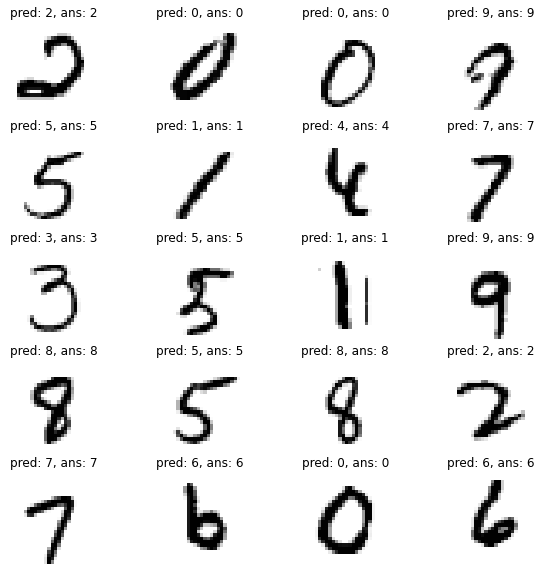

In [ ]:
plt.subplots(figsize=(10, 10))
for i in range(20):
  plt.subplot(5, 4, i+1)
  idx = random.randrange(num_test)
  plt.imshow(test_X[idx], cmap='gray_r', vmin=0, vmax=255)
  plt.axis('off')
  plt.title("pred: "+str(int(pred_y[idx]))+", ans: "+str(test_y[idx]))

Tuning hyperparameter(k) was hard; too slow.
It seems there is a faster KNN algorithm (N log N) to approach furthermore.

# Linear classifier (soft-margin SVM without kernal)

In [ ]:
train_X = np.hstack([train_X.reshape(num_train, -1), np.ones([num_train, 1])])
test_X = np.hstack([test_X.reshape(num_test, -1), np.ones([num_test, 1])])
""" Should be (60000, 785) (10000, 785). If not: reload """
print(train_X.shape, test_X.shape)

(60000, 785) (10000, 785)


In [ ]:
from classifiers.linear_classifier import LinearSVM
linearSVM = LinearSVM()
loss_history = linearSVM.train(train_X, train_y, learning_rate=5e-7, epoch=300)

Iteration: 0, loss: 9.009545176237589
Iteration: 10, loss: 1.5550571836416702
Iteration: 20, loss: 1.0660127239278037
Iteration: 30, loss: 0.926558058509153
Iteration: 40, loss: 0.8223223358221528
Iteration: 50, loss: 0.8497314909275395
Iteration: 60, loss: 0.796312701813465
Iteration: 70, loss: 0.7500413444500331
Iteration: 80, loss: 0.7563560502872919
Iteration: 90, loss: 0.7547876421103369
Iteration: 100, loss: 0.5974157299039733
Iteration: 110, loss: 0.4724747577270224
Iteration: 120, loss: 0.5742855471698377
Iteration: 130, loss: 0.4839802704566264
Iteration: 140, loss: 0.6659266352600856
Iteration: 150, loss: 0.7702274022002763
Iteration: 160, loss: 0.5240219569542877
Iteration: 170, loss: 0.5015403160366527
Iteration: 180, loss: 0.591076172037883
Iteration: 190, loss: 0.5227484728826228
Iteration: 200, loss: 0.590774980921391
Iteration: 210, loss: 0.5552533129628558
Iteration: 220, loss: 0.5521536150594869
Iteration: 230, loss: 0.4402865848301155
Iteration: 240, loss: 0.66435182

In [ ]:
pred_y = linearSVM.predict(test_X)
print(f'Got {sum(pred_y == test_y)} out of {num_test}, Accuracy: {sum(pred_y == test_y) / num_test}')

Got 9051 out of 10000, Accuracy: 0.9051


In [ ]:
""" Debug analytic gradient with numerical one """
def svm_grad_numerical_check(W, X_check, y_check, reg):
  numerical_grad = np.zeros(W.shape)
  i = np.random.choice(W.shape[0])
  j = np.random.choice(W.shape[1])
  loss, analytic_grad = svm_loss(W, X_check, y_check, reg)
  analytic_grad = analytic_grad[i][j]
  W_adjusted = W
  W_adjusted[i][j] += 1e-4
  loss_adjusted, _ = svm_loss(W_adjusted, X_check, y_check, reg)
  numerical_grad = (loss_adjusted - loss) / 1e-4
  return analytic_grad, numerical_grad

indices = np.random.choice(num_train, 256)
X_check, y_check = train_X[indices], train_y[indices]
W = np.random.randn(785, 10) * 100
analytic_grad, numerical_grad = svm_grad_numerical_check(W, X_check, y_check, 1e-5)
print(analytic_grad, numerical_grad)

3.109094469456368 3.109094686806202


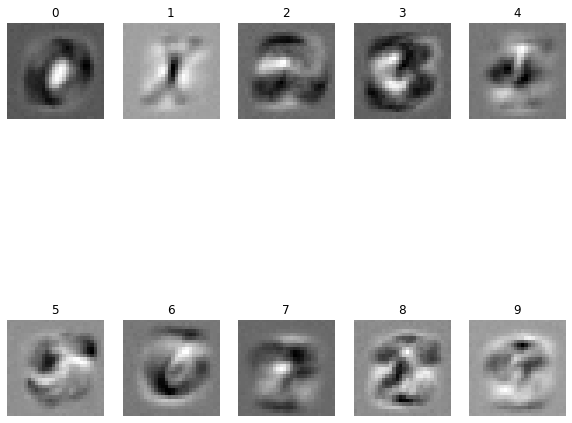

In [ ]:
""" See how template looks like """
plt.subplots(figsize=(10, 10))
w = linearSVM.W[:-1,:] # Strip out the bias
w = w.reshape(28, 28, 10)
templates = []
for i in range(10):
    plt.subplot(2, 5, i + 1)
    # Rescale the weights to be between 0 and 255
    wimg = w[:, :, i].squeeze()
    min, max = np.min(wimg), np.max(wimg)
    wimg = 255 * (wimg - min) / (max - min)
    templates.append(wimg)
    plt.imshow(wimg, cmap='gray_r', vmin=0, vmax=255)
    plt.axis('off')
    plt.title(i)

# Linear Classifier (Softmax loss)

In [ ]:
train_X = np.hstack([train_X.reshape(num_train, -1), np.ones([num_train, 1])])
test_X = np.hstack([test_X.reshape(num_test, -1), np.ones([num_test, 1])])
""" Should be (60000, 785) (10000, 785). If not: reload """
print(train_X.shape, test_X.shape)

(60000, 785) (10000, 785)


In [ ]:
""" Debug analytic gradient with numerical one """
from classifiers.loss_grad_softmax import softmax_loss
def softmax_grad_numerical_check(W, X_check, y_check, reg):
  numerical_grad = np.zeros(W.shape)
  i = np.random.choice(W.shape[0])
  j = np.random.choice(W.shape[1])
  loss, analytic_grad = softmax_loss(W, X_check, y_check, reg)
  analytic_grad = analytic_grad[i][j]
  W_adjusted = W
  W_adjusted[i][j] += 1e-7
  loss_adjusted, _ = softmax_loss(W_adjusted, X_check, y_check, reg)
  #print(f'loss_adjusted: {loss_adjusted}, loss: {loss}')
  numerical_grad = (loss_adjusted - loss) / 1e-7
  return analytic_grad, numerical_grad

indices = np.random.choice(num_train, 256)
X_check, y_check = train_X[indices], train_y[indices]
W = np.random.randn(785, 10) * 1e-4
analytic_grad, numerical_grad = softmax_grad_numerical_check(W, X_check, y_check, 1e-5)
print(f'analytic: {analytic_grad}, numerical: {numerical_grad}')

analytic: -8.848790934109148, numerical: -8.848741654965409


In [ ]:
from classifiers.linear_classifier import Softmax
softmax = Softmax()
loss_history = softmax.train(train_X, train_y, learning_rate=5e-6, epoch=300)

Iteration: 0, loss: 2.305899411609033
Iteration: 10, loss: 0.9880788239625626
Iteration: 20, loss: 0.8010652455180921
Iteration: 30, loss: 0.6360554643398378
Iteration: 40, loss: 0.6157838100414472
Iteration: 50, loss: 0.5024550901715613
Iteration: 60, loss: 0.5699508632200989
Iteration: 70, loss: 0.4666179515445286
Iteration: 80, loss: 0.45191786349899205
Iteration: 90, loss: 0.46128558963473043
Iteration: 100, loss: 0.4561574311909719
Iteration: 110, loss: 0.3847400828469719
Iteration: 120, loss: 0.35100058411705926
Iteration: 130, loss: 0.39155655711572207
Iteration: 140, loss: 0.39121680142636056
Iteration: 150, loss: 0.41700563389982037
Iteration: 160, loss: 0.41330843263210976
Iteration: 170, loss: 0.401144921216444
Iteration: 180, loss: 0.4183456944351251
Iteration: 190, loss: 0.39783621295444227
Iteration: 200, loss: 0.3350510816222786
Iteration: 210, loss: 0.3858933835973659
Iteration: 220, loss: 0.3463149995034941
Iteration: 230, loss: 0.3162850295005396
Iteration: 240, loss:

In [ ]:
pred_y = softmax.predict(test_X)
print(f'Got {sum(pred_y == test_y)} out of {num_test}, Accuracy: {sum(pred_y == test_y) / num_test}')

Got 9070 out of 10000, Accuracy: 0.907


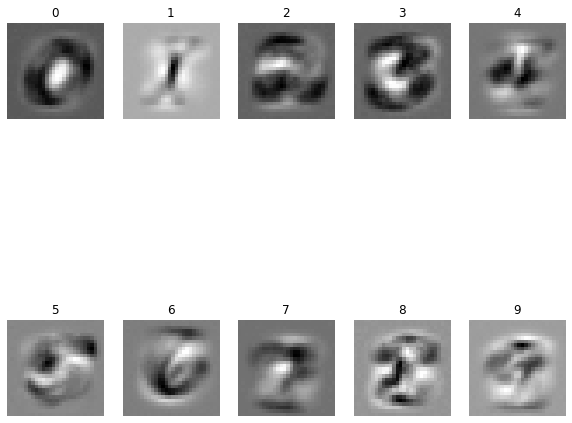

In [ ]:
""" See how template looks like """
plt.subplots(figsize=(10, 10))
w = softmax.W[:-1,:] # Strip out the bias
w = w.reshape(28, 28, 10)
templates = []
for i in range(10):
    plt.subplot(2, 5, i + 1)
    # Rescale the weights to be between 0 and 255
    wimg = w[:, :, i].squeeze()
    min, max = np.min(wimg), np.max(wimg)
    wimg = 255 * (wimg - min) / (max - min)
    templates.append(wimg)
    plt.imshow(wimg, cmap='gray_r', vmin=0, vmax=255)
    plt.axis('off')
    plt.title(i)

# Fully Connected Neural Network

In [ ]:
train_X = train_X.reshape(num_train, -1)
test_X = test_X.reshape(num_test, -1)
print(train_X.shape, test_X.shape)

(60000, 784) (10000, 784)


In [ ]:
from classifiers.neural_network import NeuralNetwork
fc_net = NeuralNetwork(input_dim=784, num_classes=10, hidden_dims=[300, 100], initial_weight=1e-2, reg=0)
indices = np.random.choice(60000, 256)
dev_X = train_X[indices]
dev_y = train_y[indices]
fc_net.train(train_X, train_y, 1e-2, 500, batch_size=256)

Iteration: 0, loss: 2.3047753836854357
Iteration: 10, loss: 1.664506705758015
Iteration: 20, loss: 1.0172731435480298
Iteration: 30, loss: 0.8943263209076621
Iteration: 40, loss: 0.7635174598106242
Iteration: 50, loss: 0.5735003222642692
Iteration: 60, loss: 0.5104601721780174
Iteration: 70, loss: 0.34756263153222655
Iteration: 80, loss: 0.38490292225290407
Iteration: 90, loss: 0.28988450641060415
Iteration: 100, loss: 0.16934304124192553
Iteration: 110, loss: 0.23173362093552508
Iteration: 120, loss: 0.3152596507713062
Iteration: 130, loss: 0.27231992954246526
Iteration: 140, loss: 0.32285133957213663
Iteration: 150, loss: 0.22826579958564938
Iteration: 160, loss: 0.28619885652715255
Iteration: 170, loss: 0.18186605030428582
Iteration: 180, loss: 0.2928337713903608
Iteration: 190, loss: 0.2935989146440592
Iteration: 200, loss: 0.18452802088251957
Iteration: 210, loss: 0.1513223405753382
Iteration: 220, loss: 0.15433853812156673
Iteration: 230, loss: 0.27031395242817213
Iteration: 240,

In [ ]:
pred_y = fc_net.predict(test_X)
print(f'Got {sum(pred_y == test_y)} out of {num_test}, Accuracy: {sum(pred_y == test_y) / num_test}')

Got 9634 out of 10000, Accuracy: 0.9634


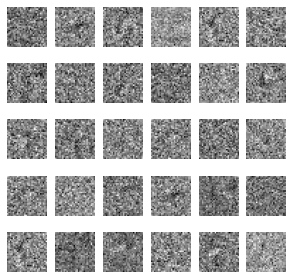

In [ ]:
""" See how template looks like """
plt.subplots(figsize=(5, 5))
W1, W2, W3 = fc_net.params['W1'], fc_net.params['W2'], fc_net.params['W3']
W1 = W1.reshape(28, 28, -1)
templates = []
indices = np.random.choice(300, 30)
for i in range(30):
    plt.subplot(5, 6, i + 1)
    # Rescale the weights to be between 0 and 255
    wimg = W1[:, :, indices[i]].squeeze()
    min, max = np.min(wimg), np.max(wimg)
    wimg = 255 * (wimg - min) / (max - min)
    templates.append(wimg)
    plt.imshow(wimg, cmap='gray_r', vmin=0, vmax=255)
    plt.axis('off')